# Interior Point Methods For Linear Problems

In this text, we will present alternative methods for the Simplex algorithm for solving linear problems. While Dantzig's simplex searches for solutions in the border of the feasible region, the so-called Interior Point methods follows its iterations inside the feasible region.

Introducing the notation, our primal linear program will be:

\begin{align*}
&\min_{x} c^T x\\
\text{s. t. }&Ax=b\\
&x\geq 0
\end{align*}
where $A$ is an $m\times n$ matrix, and its dual version:

$$
\max_{p} b^T p\\
\text{s. t. } A^Tp\leq c$$


## Affine Scaling Algorithm

Affine Scaling is the most classical interior point algorithm. Instead of optimizing over the entire feasible region, we'll reduce the feasibility to an ellipsoid contained in it, then we can find an analytical solution, and iterate this whole process until we reach the optimal value within a tolerance that is calculated through the duality gap. The optimal value of an iteration is used as the center of the next feasible ellipsoid.

Define the feasible region as $F=\{x\in \mathbb{R}^n|Ax=b,x\geq0\}$, the subset of $F$ $\{x\in F|x>0\}$ is called the set of interior points.

Given $y>0$ a feasible and interior solution, the following lemma establishes a feasible ellipsoid $S$ centered in $y$.

**Lemma 1:** Let $\beta\in(0,1)$ and $y>0$ and

$$S=\Big\{x\in\mathbb{R}^n\big|\sum_{i=1}^n\dfrac{(x_i-y_i)^2}{y_i^2}\leq\beta^2\Big\},$$

then if $x\in S$ then $x>0$.

**Proof:** For a given $x\in S$, we have for each $x_i$:

$(x_i-y_i)^2\leq y_i^2\beta^2<y_i^2$, and since $y_i>0$ we can take the square root and get $|x_i-y_i|< y_i$ which implies $y_i-x_i< y_i$, where we conclude $x_i>0$. **Q.E.D**

If we define $Y=diag(y_1,\ldots,y_n)$ i.e, a diagonal matrix where the i-th entry is $y_i$, we can rewrite the ellipsoid inequation as:

$$||Y^{-1}(x-y)||\leq\beta$$

We can now redefine the problem to minimize over $S$:

\begin{align*}
&\min_{x} c^T x\\
\text{s. t. }&Ax=b\\
&||Y^{-1}(x-y)||\leq\beta
\end{align*}

Since $y$ is feasible, $Ay=b$, and we can define a new variable $d=x-y$, and modify the problem again:

\begin{align}
&\min_{x} c^T d\\
\text{s. t. }&Ad=0\\
&||Y^{-1}d||\leq\beta
\end{align}

The following lemma states an analytical solution for this problem guaranteeing that the optimal step $d$ keeps the point in the feasible set and the objective function is strictly minimized.

**Lemma 2:** Assume $rank(A)=m$ and that $c\notin span(A)$. Given $y>0$ the optimal solution of the above LP is:

$$d^*=-\beta\dfrac{Y^2(c-A^Tp)}{||Y(c-A^Tp)||},$$

where $$p=(AY^2A^T)^{-1}AY^2c.$$

Furthermore, $x = y +d^*$ belongs to the feasible set $F$, and 

$$c^Tx<c^Ty$$

**Proof:** The rank and span conditions in $A$ are linear algebra details to guarantee that $AY^2A^T$ is invertible and $p$ and $d^*$ are well-defined. Such details can be found in [[2]](#References), here we'll prove the feasibility and optimality of $d^*$ without worrying about this.

To prove feasibility we need: $Ad^*=0$ and $||Y^-1d^*||\leq\beta$, for the first, we just need to show that $AY^2(c-A^Tp}=0:$

\begin{align*}
AY^2(c-A^Tp)&=AY^2(c-A^T(AY^2A^T)^{-1}AY^2c)\\
&=AY^2(c-A^T(A^T)^{-1}Y^{-2}A^{-1}AY^2c)\\
&=AY^2(c-Y^{-2}Y^2c)\\
&=AY^2(c-Ic)\\
&=0
\end{align*}

Since $Y^{-1}d^*=\beta\dfrac{Y(c-A^Tp)}{||Y(c-A^Tp)||}$, we can easily see that $||Y^{-1}d^*||=\beta$, satisfying the constraint inequality.

To prove optimatily, we take a feasible $d$, i.e, $Ad=0$ and $||Y^{-1}d||\leq\beta$. Using this and Schwarz inequality we can get:

\begin{align*}
c^Td&=(c^T-p^TA)d\\
&=(c^T-p^TA)YY^{-1}d\\
&=(c-A^Tp)^TYY^{-1}d\\
&\geq-||Y(c-A^Tp)||\cdot||Y^{-1}d||\\
&\geq-\beta||Y(c-A^Tp)||
\end{align*}

One can prove using the same strategy that $c^Td^*=-\beta||Y(c-A^Tp)||$, proving that $d^*$ is optimal. Furthermore, the objective function is reduced:
\begin{align*}c^Tx&=c^T(y+d^*)\\&=c^Ty+c^Td^*\\&=c^Ty-\beta||Y(c-A^Tp)||\\&<c^Ty\end{align*}

The feasibility of $x=y+d^*$ follows from Lemma 1.

The reference [2](#References) also show that the $p$ from Lemma 2 is the dual feasible solution for $y$. Then can write the duality gap as:

\begin{align*}
c^Ty-b^Tp&=c^Ty-(Ay)^Tp\\
&=c^Ty-y^TA^Tp\\
&=y^T(c-A^Tp)
\end{align*}

We define $s=(c-A^Tp)$ as the dual slackness. Such a simple formula for the gap as $y^Ts$ give us direct way for computing stopping conditions, using minimum tolerance $\varepsilon$ for this gap.

The algorithm starts with a feasible solution $x^{(0)}$, computes the optimal value inside the ellipsoid centered at $x^{(0)}$ using the above concepts, and uses this value as the center for the next ellipsoid until we reach the duality gap tolerance.

The algorithm:

**Inputs:** 

- the problem $(A,b,c)$
- initial primal feasible value $x^{(0)}>0$
- optimality tollerance $\varepsilon$

**1. (Initialization)** Starts iteration k=0, with the initial solution

**2. (Dual Slackness computation)** Given $x^{(k)}>0$, sets

\begin{align*}X_k&=diag(x^{(k)}_1,\ldots,x^{(k)}_n)\\
p_k&=(AX_k^2A^T)^{-1}AX_k^2c\\
s_k&=c-A^Tp_k\end{align*}

**3. (Optimatily check)** If $s_k>0$ and $s_k^Tx^{(k)}<\varepsilon$, the stops the algorithm and outputs $x^{(k)}$ as the primal approximate optimal solution.

**4. (Solution update)** Set

$$x^{(k+1)}=x^{(k)}-\beta \dfrac{X^2_ks_k}{||X_ks_k||}$$


In [7]:
include("affine_scaling.jl")
include("primal_dual_path_following.jl")

primal_dual (generic function with 1 method)

In [6]:
using LinearAlgebra
x1_traj, x2_traj = affine_scaling(c, A, b, x0)


(Any[0.5, 0.7187950844181372, 0.9734094966818237, 1.1933722830280562, 1.3320452261278177, 1.4056266974356113, 1.4411665406665262, 1.4547122133512849, 1.4535224187951656, 1.4418639821832846  …  0.9999999841297713, 0.9999999905272314, 0.9999999905272314, 1.0000000007331245, 0.9999999849454431, 0.9999999605231927, 0.9999998849647512, 0.9999998849647512, 0.9999998849647512, 0.9999998849647512], Any[0.03, 0.030856006304916823, 0.03148269600921397, 0.03207421584417221, 0.03297425038316854, 0.03475132267562499, 0.03856451833888224, 0.04699699416086124, 0.06419302699234414, 0.09339642702423565  …  0.9999999838182723, 0.9999999795532989, 0.9999999927484283, 1.0000000080572677, 1.0000000159511087, 0.9999999915288568, 1.00000002930808, 1.0000000877494506, 1.0000000877494506, 1.0000000877494506])

In [2]:
c = [-1, -1, 0, 0]
A = [1 2 1 0 ;
     2 1 0 1 ]
b = [3, 3]

2-element Vector{Int64}:
 3
 3

In [3]:
# x1_traj, x2_traj = affine_scaling(c, A, b, x0)
# Initial Starting Solution
x1 = 0.5
x2 = 0.03
# x0 = [0.5, 0.03, 2.44, 1.97]
x0 = [x1, x2, 3-x1-2*x2, 3-2*x1-x2]

4-element Vector{Float64}:
 0.5
 0.03
 2.44
 1.97

(Any[0.5, 0.7187950844181372, 0.9734094966818237, 1.1933722830280562, 1.3320452261278177, 1.4056266974356113, 1.4411665406665262, 1.4547122133512849, 1.4535224187951656, 1.4418639821832846  …  0.9999999841297713, 0.9999999905272314, 0.9999999905272314, 1.0000000007331245, 0.9999999849454431, 0.9999999605231927, 0.9999998849647512, 0.9999998849647512, 0.9999998849647512, 0.9999998849647512], Any[0.03, 0.030856006304916823, 0.03148269600921397, 0.03207421584417221, 0.03297425038316854, 0.03475132267562499, 0.03856451833888224, 0.04699699416086124, 0.06419302699234414, 0.09339642702423565  …  0.9999999838182723, 0.9999999795532989, 0.9999999927484283, 1.0000000080572677, 1.0000000159511087, 0.9999999915288568, 1.00000002930808, 1.0000000877494506, 1.0000000877494506, 1.0000000877494506])

In [5]:
m = size(A,1)
# A\zeros(n,1)
b-A*[0.5;0.03;0;0]

2-element Vector{Float64}:
 2.44
 1.97

In [7]:
p0=[-1;-1]
x = x0
p = p0
s = c-A'*p
rho=0.5
n = size(A,2)
m = size(b,1)
e = ones(size(x,1),1)


# Newton's Step
mu = rho*dot(x,s)/m
X = Diagonal(x)
S = Diagonal(s)
LHS =  [A zeros(m,m) zeros(m,n);
     zeros(n,n) A' I;
    S zeros(n,m) X]
RHS = [zeros(n,1); zeros(m,1); mu*e-X*S*e]
LHS
dot(s,x)
s

4-element Vector{Int64}:
 2
 2
 1
 1

In [8]:
# dx = d[1:n]
# println(dx)
# println(x)
# alpha=0.1
# println(-alpha*x[dx.<0]./dx[dx.<0])
# 2.44/-0.52401550707

LoadError: UndefVarError: d not defined

In [11]:
x1_traj_pd, x2_traj_pd = primal_dual(c,A,b,x0,p0; beta=0.5, epsilon=1e-9, max_iter=1000,alpha=0.9)
size(x1_traj_pd)

(34,)

In [216]:
x2_traj_pd[end]

0.9999999998408022

In [223]:
x1_traj_a, x2_traj_a = affine_scaling(c, A, b, x0)
size(x1_traj_a),abs(x1_traj_pd[end]-x1_traj_pd[end-1])

((58,), 1.5919798812547015e-10)

In [210]:
x1_traj_a[end],x2_traj_a[end],x1_traj_pd[end],x2_traj_pd[end]

(0.9999998849647512, 1.0000000877494506, 0.9999999998706265, 0.9999999998706267)

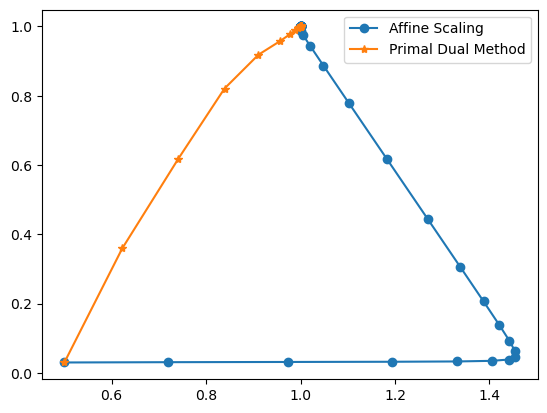

PyObject <matplotlib.legend.Legend object at 0x000000004DFB18E0>

In [214]:
using PyPlot
fig = figure()
plot(x1_traj_a, x2_traj_a, "o-", label="Affine Scaling")
plot(x1_traj_pd, x2_traj_pd, "*-", label="Primal Dual Method")
legend(loc="upper right")
# savefig("primal_path_following.pdf")
# savefig("primal_path_following.png")
# close(fig)

## References 

[1] Kwon, C. (2019). Julia Programming for Operations Research 2/e. Softcover.Io. https://www.softcover.io/read/7b8eb7d0/juliabook2/interior#cid40

[2] Bertsimas, D., Tsitsiklis, J. N., & Tsitsiklis, J. (1997). Introduction to Linear Optimization (Athena Scientific Series in Optimization and Neural Computation, 6) (1st ed.). Athena Scientific.